## Introduction
This data science project is based on the competition hosted by Driven Data Labs (https://www.drivendata.org/competitions). The objective is to predict the incidence of dengue cases in San Juan, Puerto Rico and Iquitos, Peru, using historical weekly climate data and corresponding weekly incidence of dengue cases (data provided by Driven Data Labs).
<br>

This project is currently a work in progress, updated versions will be uploaded when completed.
<br>

#### Understanding and framing the problem
The overall objective is to answer the question: How do local climate variables affect dengue spread in San Juan and Iquitos?
<br>
In summary:
- Dengue incidence depends on dengue vector (mosquito) abundance and competence as well as human behaviour, which in turn depend on local climate and environmental variables
- Climate variables (humidity/heat/precipitation) affect vector/mosquito abundance and competence by influencing mosquito breeding and development rates.
- Dengue-infected humans affect disease spread by becoming potential hosts to uninfected mosquitos, which then go on to infect more humans, the cycle continues.
- In general, mosquitos take 7-10 days to develop from egg to adult and have a 7-21 day life span. Dengue symptoms in infected humans manifest 4-6 days after infection and are viable hosts to uninfected mosquitos from 4-10 days after infection.
- Hence, to predict today's dengue case count, trends for climate variables *in the preceding weeks* must be assessed. The most influential lag-variables can then be identified and used for predicting future cases.  

<br>
<br>

#### Evaluation metric
- The competition uses MAE (mean absolute error) to assess submissions. This metric denotes the mean absolute difference between all predicted and actual values. 

#### Baseline model
For the baseline model, I will work only with the original features in the dataset (historical climate data). This would provide a measure of how useful the original features are as well as a benchmark to compare future models. Hence, our baseline hypothesis is:
- Future dengue incidence can be modelled directly from local historical climate variables
<br>
<br>
Based on the baseline model results, we can then refine our strategies and construct more complex models, incorporating dengue vector (mosquito) growth cycles and human behaviour 
<br>
<br>
##  Data relevance and integrity
A ML model can only be as good as the data it was modelled on. There's no point using features/data that do not adequately describe the real-world phenomena one is trying to model. Hence, it is imperative that any dataset be evaluated by answering the following questions: 
- Q1) Is the data relevant to the real-world phenoma being modelled? 
- Q2) Does the data have sufficient integrity? 
- Q3) Does the data add value to the model? 
<br>

### Information on features
The list of features and their sources are shown below (taken from the Driven Data DengAi competition homepage). 
<br>

#### City and date indicators
city – City abbreviations: sj for San Juan and iq for Iquitos
<br>
week_start_date – Date given in yyyy-mm-dd format
<br>

#### NOAA's GHCN daily climate data weather station measurements
station_max_temp_c – Maximum temperature
<br>
station_min_temp_c – Minimum temperature
<br>
station_avg_temp_c – Average temperature
<br>
station_precip_mm – Total precipitation
<br>
station_diur_temp_rng_c – Diurnal temperature range
<br>
<br>

#### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
precipitation_amt_mm – Total precipitation
<br>
<br>


#### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
reanalysis_sat_precip_amt_mm – Total precipitation
<br>
reanalysis_dew_point_temp_k – Mean dew point temperature
<br>
reanalysis_air_temp_k – Mean air temperature
<br>
reanalysis_relative_humidity_percent – Mean relative humidity
<br>
reanalysis_specific_humidity_g_per_kg – Mean specific humidity
<br>
reanalysis_precip_amt_kg_per_m2 – Total precipitation
<br>
reanalysis_max_air_temp_k – Maximum air temperature
<br>
reanalysis_min_air_temp_k – Minimum air temperature
<br>
reanalysis_avg_temp_k – Average air temperature
<br>
reanalysis_tdtr_k – Diurnal temperature range
<br>
<br>


#### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
ndvi_se – Pixel southeast of city centroid
<br>
ndvi_sw – Pixel southwest of city centroid
<br>
ndvi_ne – Pixel northeast of city centroid
<br>
ndvi_nw – Pixel northwest of city centroid
<br>
<br>

#### Notes 
Dew point and humidity
- Dew point indicates the amount moisture in the air. The higher the dew points, the higher the moisture content of the air at a given temperature. Dew point temperature is defined as the temperature to which the air would have to cool (at constant pressure and constant water vapor content) in order to reach saturation.  

- When the dew point temperature and air temperature are equal, the air is said to be saturated. Dew point temperature is NEVER GREATER than the air temperature. Therefore, if the air cools, moisture must be removed from the air and this is accomplished through condensation. This process results in the formation of tiny water droplets that can lead to the development of fog, frost, clouds, or even precipitation. (summarise and ref)
<br>
- If air temp is less than dew point temp, then condensation occurs. 
- Relative Humidity can be inferred from dew point values. When air temperature and dew point temperatures are very close, the air has a high relative humidity. The opposite is true when there is a large difference between air and dew point temperatures, which indicates air with lower relaitve humidity. Locations with high relative humidities indicate that the air is nearly saturated with moisture; clouds and precipitation are therefore quite possible. 
(ref: http://ww2010.atmos.uiuc.edu/(Gh)/guides/maps/sfcobs/dwp.rxml)
<br>
<br>

Reanalysis data
<br>
The reanalysis data are derived largely from satellite readings (non-local measurements, more info at https://reanalyses.org/reanalysesorg-home-page). Hence these data should only be used if there are no direct local measurements available.
<br>

Station weather data
<br>
These data are local measurements made by ground-based weather stations.
<br>

From the info above, it seems that all features in this dataset are indeed relevant to build our model to predict dengue cases. The next sections will focus on exploratory data analysis (EDA) of the dataset to answer Q2 and Q3.

In [3]:
### Import necessary modules and packages 
# standard modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

# visualise missing data
import missingno as msno

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import TimeSeriesSplit

# Validation 
from sklearn.metrics import mean_absolute_error

# Regressors and classifiers
from sklearn.ensemble import RandomForestRegressor

# Stats modules
import dc_stat_think as dcst
from scipy import stats
import statsmodels.api as sm

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

# Prediction algorithms
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error

In [34]:
# Custom functions

# Construct a function to automatically compute the p-value of a column to test lognormal using K-S stat
def derive_lognormal(lognorm_data, empirical_data):
    ## test the hypothesis that the data follows a lognormal distribution as measured by the K-S stat##
   
    # derive parameters that describe the observed data 
    mean_data = np.mean(lognorm_data)
    std_data = np.std(lognorm_data)
    
    # draw the theoretical exponential distribution using mean derived from observed data
    generated = np.random.lognormal(mean_data, std_data, size=10000)
    
    # compute the empirical K-S stat
    emp_KS = dcst.ks_stat(empirical_data, generated)
    
    # generate the K-S replicates
    generated_KS = dcst.draw_ks_reps(len(lognorm_data), np.random.lognormal, args=(mean_data,std_data),
                                     size=10000, n_reps=10000)                                                              
    # derive and return the p-value
    p_value = np.sum(generated_KS >= emp_KS)/len(generated_KS)
    return print('The p value for', lognorm_data.name, 'for 10000 K-S reps is {}'.format(p_value))

# Generate theoretical lognormal curves and overlay with empirical lognormal curve of a dataset

def compare_lognormal_cdf(lognorm_data, empirical_data):
    ## Compute and plot the ecdf and overlay it with its theoretical boostrapped cdf##
    # Compute paramaters describing the data (comparing to bs lognormal dist so std and mean)
    mean_data = np.mean(lognorm_data)
    std_data = np.std(lognorm_data)
    
    # Generate the theoretical poisson distribution with parameters derived from observed data
    generated = np.random.lognormal(mean_data, std_data, size=10000)
    
    # Plot the ecdf with dots and no line
    _ = plt.figure(figsize=(10,6))
    _ = plt.plot(*dcst.ecdf(empirical_data), marker='.', linestyle='none', label=empirical_data.name)
    
    # Plot the theoretical cdf as a solid line
    _ = plt.plot(*dcst.ecdf(generated), label='Theoretical Lognormal CDF')
    
    # Labels and axes details
    _ = plt.legend(fontsize=15)
    _ = plt.xlabel(empirical_data.name, fontsize=15)
    _ = plt.ylabel('CDF', fontsize=15)
    _ = plt.title('Empirical vs Theoretical Lognormal CDF for {}'.format(empirical_data.name), 
                  fontsize=18)
    plt.show()
    
#Function to compute lag factors of target df and compute spearman correlations
def derive_lag_and_spearman(df, column, period, start, end):
    for i in range(period, start, end):
        df['t-'+str(i)] = df[column].shift(i).values
    return print(df.corr(method='spearman').head(2))

### Data preparation
The features (date and climate data) and response/target variable (total case count) are organised based on weekly observations and our objective is to predict the weekly incidence of dengue cases. Hence I will use 'week_start_date' as the index for the pandas dataframe to standardise the features and labels data to weekly observations.
<br>
<br>
I first use pandas to import the features dataset, using 'week_start_date' as the index column, parsing the values into a datetime index in a dataframe. As the labels are in a separate file I chose columns 0 and 1 for year and city respectively as the index.

In [5]:
# Define access folder
os.chdir("D:\Coding related\Driven Data related\DengAi comp\datasets")

# Read in datasets
df_ori_features = pd.read_csv('dengue_features_train.csv', index_col =['week_start_date'], header=0, 
                              parse_dates=True)
df_ori_labels = pd.read_csv('dengue_labels_train.csv', index_col =[0,1], header=0)
df_test = pd.read_csv('dengue_features_test.csv', index_col =['week_start_date'], header=0, 
                      parse_dates=True)
df_sub = pd.read_csv('submission_format.csv', index_col=[0,1], header=0)

# Create a copy of the original features df to work with
df_feat = df_ori_features.copy()

From the literature and domain knowledge, I understand that dengue incidence is influenced by local environmental variables. Hence, I need to build two separate dengue prediction models using the features and labels relevant to each city. I subset the features and labels by city and combine them into two separate dataframes, one for San Juan (SJ) and the other for Iquitos (Iq) respectively.

In [6]:
# Split datasets into separate cities
# Isolate San Juan and Iquitos data into separate dfs and drop the rudundant drop city column
sj_feat = df_feat.loc[df_feat['city'] == 'sj'].drop('city', axis=1) 
iq_feat = df_feat.loc[df_feat['city'] == 'iq'].drop('city', axis=1) 

# Isolate labels for sj and iq
sj_labels = df_ori_labels.loc['sj']
iq_labels = df_ori_labels.loc['iq']

# Add corresponding total_cases data to sj_feat and iq_feat dfs
sj_feat['total_cases'] = sj_labels.loc[:,('total_cases')].values
iq_feat['total_cases'] = iq_labels.loc[:,('total_cases')].values

# Check the shape of the new dfs 
print('sj labels shape: {}'.format(sj_labels.shape))
print('shape of df with sq data: {}'.format(sj_feat.shape))
print('shape of df with iq data: {}'.format(iq_feat.shape))

# Backup sorted dfs to csv files
#sj_feat.to_csv('sj_feat_with_labels.csv')
#iq_feat.to_csv('iq_feat_with_labels.csv')

sj labels shape: (936, 2)
shape of df with sq data: (936, 23)
shape of df with iq data: (520, 23)


I'll focus on the SJ data and model building first. To start, I'll do some basic integrity checks for missing, duplicate or erroneous values in the data.

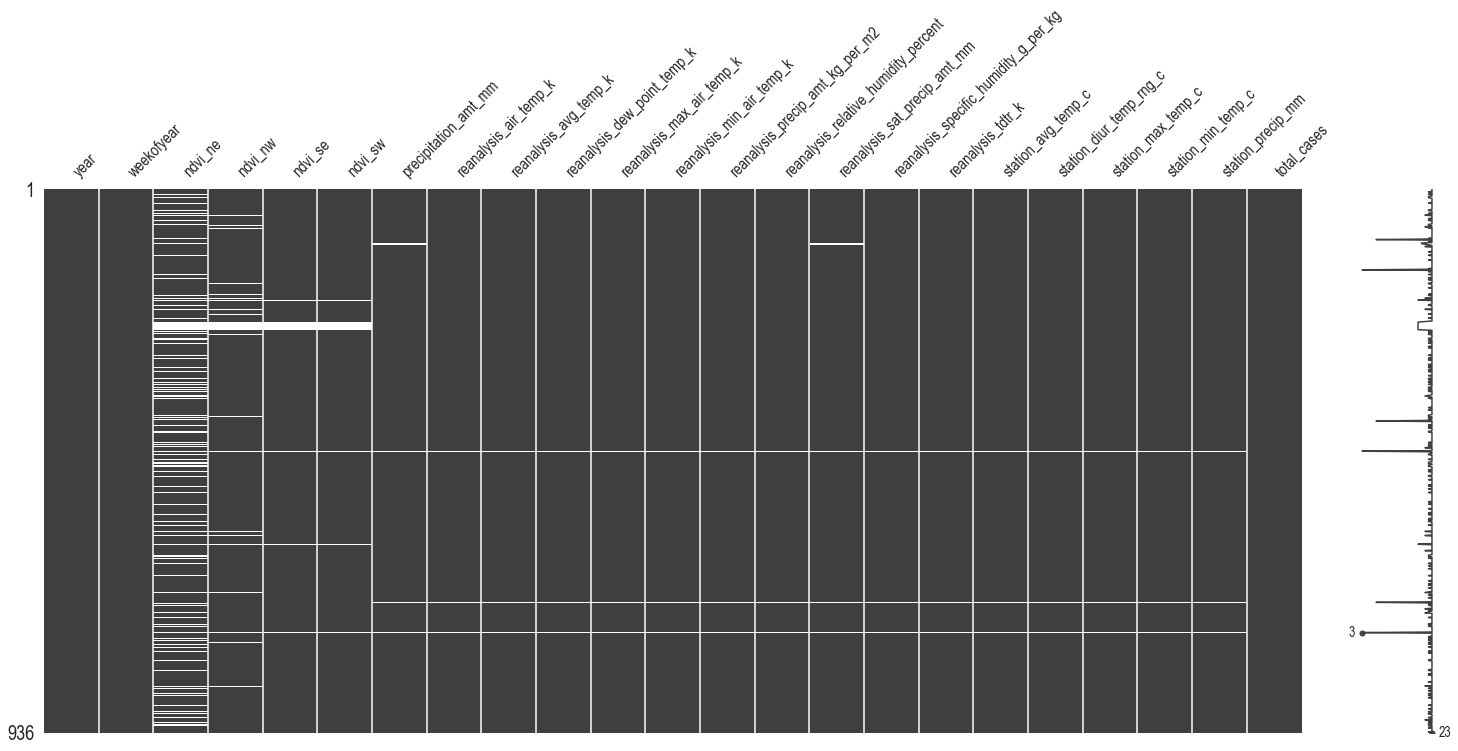

In [7]:
# EDA - Identify missing data
sns.set()
np.random.seed(42)
_ = msno.matrix(sj_feat)
plt.show()

In the figure above, the white (or unfilled) segments in each column represent missing data for each feature. All features have some NaN values except 'year' and 'weekofyear', however a large chunk is missing in the ndvi columns. Ndvi_ne seems to be missing more than half its data. 

In [8]:
# EDA - summary statistics
pd.set_option('display.max_columns', 500) #get pandas to display all columns
print(sj_feat.describe())

              year  weekofyear     ndvi_ne     ndvi_nw     ndvi_se  \
count   936.000000  936.000000  745.000000  887.000000  917.000000   
mean   1998.826923   26.503205    0.057925    0.067469    0.177655   
std       5.212076   15.021909    0.107153    0.092479    0.057166   
min    1990.000000    1.000000   -0.406250   -0.456100   -0.015533   
25%    1994.000000   13.750000    0.004500    0.016425    0.139283   
50%    1999.000000   26.500000    0.057700    0.068075    0.177186   
75%    2003.000000   39.250000    0.111100    0.115200    0.212557   
max    2008.000000   53.000000    0.493400    0.437100    0.393129   

          ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  917.000000            927.000000             930.000000   
mean     0.165956             35.470809             299.163653   
std      0.056073             44.606137               1.236429   
min     -0.063457              0.000000             295.938571   
25%      0.129157              0.000000

- The 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' features have the exact same summary statistics, indicating these are duplicate features. Additionally, the high max value compared to their mean and standard deviation (std) also suggest that large outliers may be present
- Large outliers may also be present int the 'station_precip_mm'
- The station_max_temp_c and station_min_temp_c data are rounded off to 1 decimal place

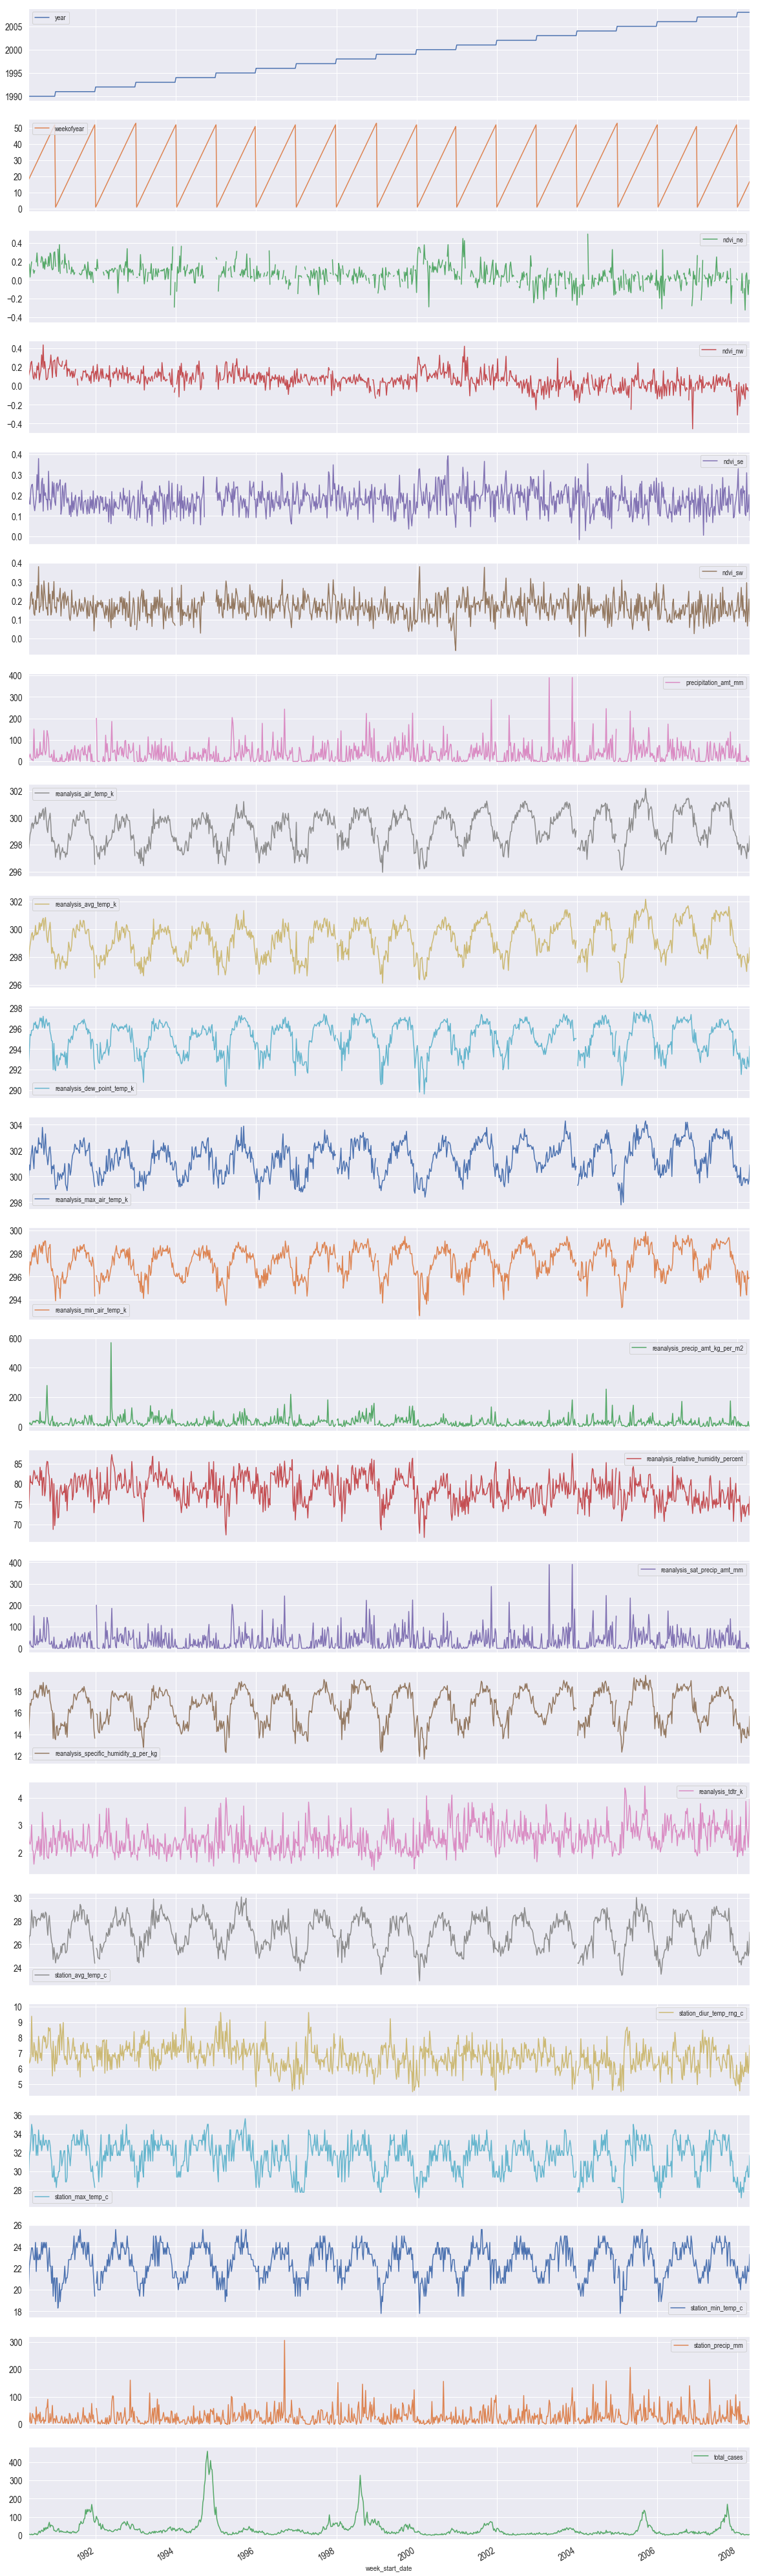

In [9]:
sns.set() #use Seaborn-style plots
#EDA - plot the raw curves for SJ data
_ = sj_feat.plot(subplots=True, figsize=(20,80), fontsize=15)
plt.show()

Visual EDA of raw features data:
- There are missing values for several features (also mentioned in the competition description). 
- All features except 'year' and 'weekofyear' appear to be very noisy 
- Seasonality is evident for temperature features
- There appears to be outliers in the 'station_precip_mm' and 'reanalysis_precip_amt_kg_per_m2' data
- The precipitation_amt_min and reanalysis_sat_precipitation_amt_min columns appear to be identical, these could be duplicate features 
<br>

Visual EDA of the response variable/label (total_cases)
- The are large spikes in total_cases counts in several years which indicate outbreak periods, the largest spike occuring in 1994. 
- Seasonality is also evident, shown by an increase in dengue cases in the last quarter of each year

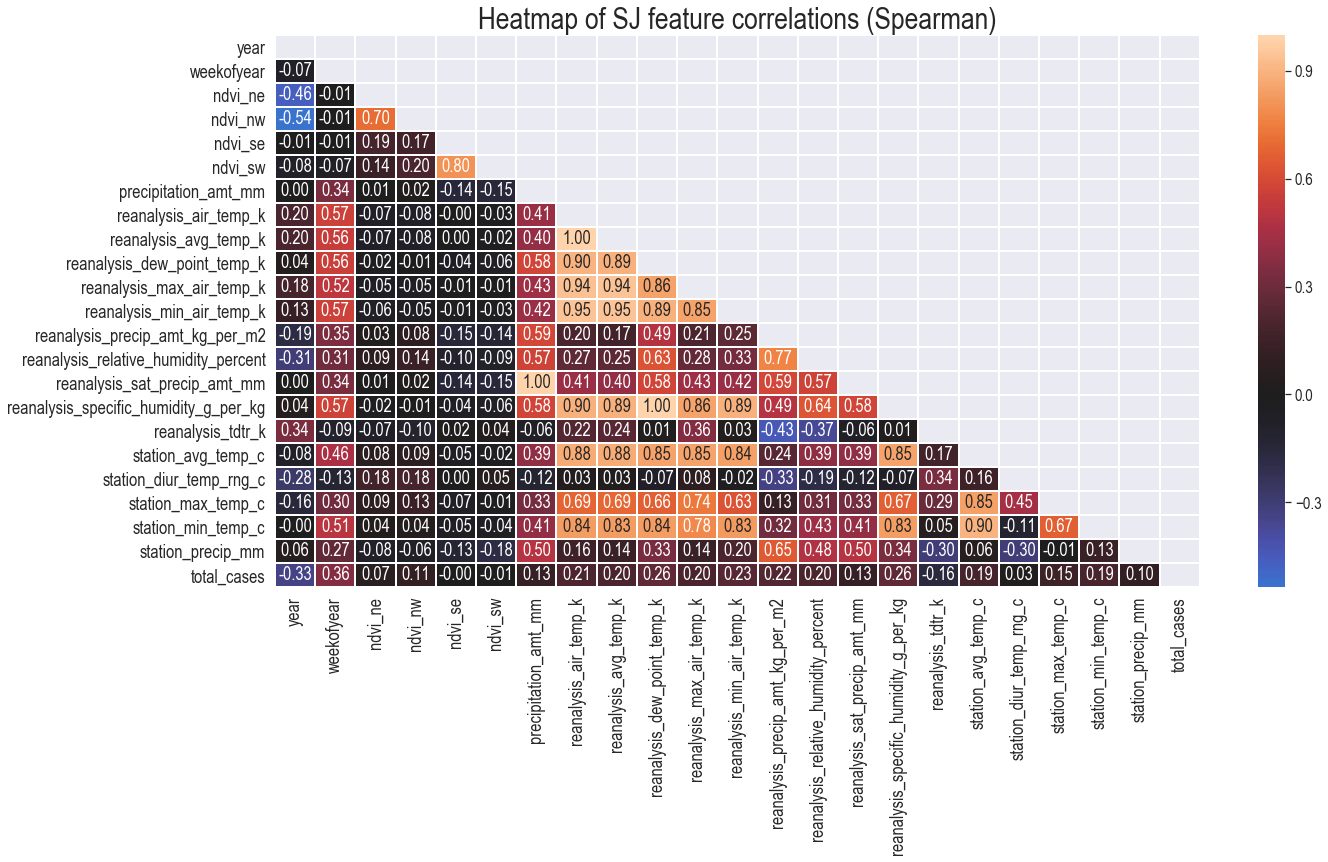

In [10]:
# Compute Spearman correlation and drop duplicate features

# Plot a heatmap of Spearman correlations
# Create the correlation matrix
sj_corr = sj_feat.corr(method='spearman')

# Generate a mask for the upper triangle, so we leave out duplicate information 
mask_corr = np.triu(np.ones_like(sj_corr, dtype=bool))

# Add the mask to the heatmap
sns.set(font_scale=1.5)
_ = plt.figure(figsize=(20,12))
_ = plt.title('Heatmap of SJ feature correlations (Spearman)', fontsize=30)
_ = sns.heatmap(sj_corr, mask=mask_corr, center=0, linewidths=1, annot=True, fmt=".2f")
_ = plt.tight_layout()
_ = plt.xticks(rotation=90, fontsize=18)
_ = plt.yticks(fontsize=18)
#plt.savefig('D:\Coding related\Driven Data related\DengAi comp\datasets\saved figures\strategy 8 - dimensionality reduction\Heat mod_sj spearman.png')
plt.show()

From the heatmap:
- reanalysis_air_temp_k and reanalysis_avg_temp_k are also perfectly correlated indicating duplicate features
- reanalysis_specific_humidity_g_per_kg is perfectly correlated with reanalysis dew_point_temp_k, ring because they are measuring the same phenoma: the mass of water in the air (humidity)
- reanalysis_air_temp_k is perfectly correlated with renalysis_avg_temp_k

The code in the next section automates the removal of perfectly correlated features (defined as >0.99 Spearman score) and creates a new dataframe

In [11]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = sj_feat.corr(method='spearman').abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.99)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.99)]

# Drop the features in the to_drop list
sj_feat_reduced = sj_feat.drop(to_drop, axis=1)
print('The original dataframe has {} columns'.format(sj_feat.shape[1]))
print("The reduced dataframe has {} columns".format(sj_feat_reduced.shape[1]))
print(sj_feat_reduced.columns)

The original dataframe has 23 columns
The reduced dataframe has 20 columns
Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')


#### Preliminary feature selection
- At this stage it is reasonable to conclude that 'ndvi_ne' has too many missing values to be useful. Additionally, the large missing chunk in the other ndvi features is too large a gap for standard filling or interpolation techniques (would be far off the true measurement). It is possible to take the average values of all other years to fill in this gap, however that would potentially be a biased and unrealistic representation of actual vegetation growth which does not help the model capture what is happening in reality. Since we have many other features to work with and the fact that ndvi data has not been shown to be very informative for predicting dengue cases (refs), I elected to drop the ndvi features from the dataset. 

- The gap in the ndvi data also coincides with the largest spike in total_cases. Imputing these values from the average of other years would bias the model towards years without the epidemic   

- Since there is good data from the weather station measurements describing actual local weather conditions, we can omit the reanalysis temperature data as this would just be duplicate information that is not representative of local conditions.

- I will also drop the 'year' column as this columns does not help future predictions. 

- 'reanalysis_precip_amt_kg_per_m2' and 'reanalysis_sat_precip_amt_mm' are actually measuring the same phenomena in the same units, just on different spacial scales. Additionally, reanalysis_sat_precip_amt_mm is the non-local equivalent of station_amt_mm. Hence, I will drop reanalysis_sat_precip_amt_mm

In [12]:
# EDA - drop ndvi and year columns
sj_feat_1= sj_feat_reduced.drop(['year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 
                         'reanalysis_avg_temp_k', 'reanalysis_sat_precip_amt_mm',
                          'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
                         'reanalysis_tdtr_k'], axis=1)
print(sj_feat_1.shape)

(936, 10)


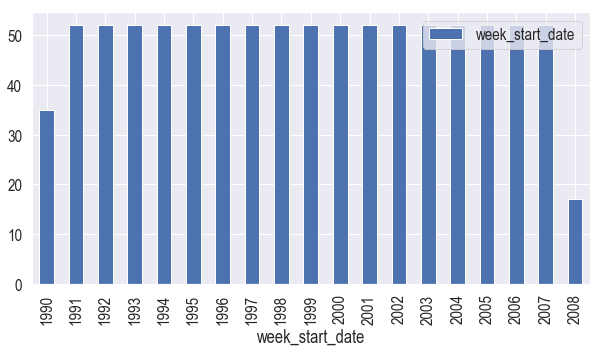

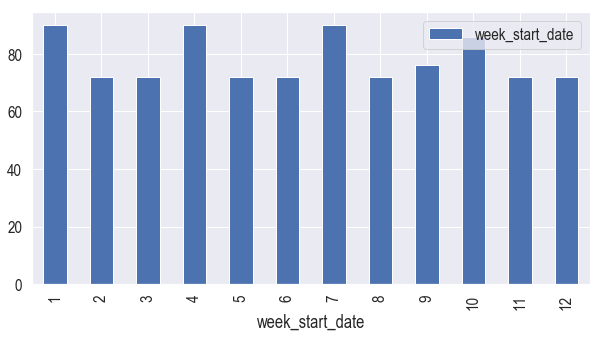

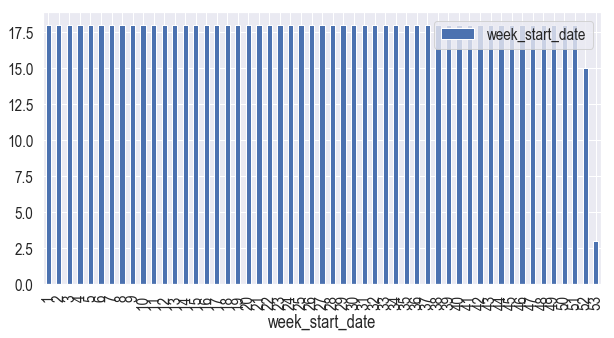

In [13]:
# Investigating the integrity of 'week_start_date' timeline

sj_reset = sj_feat_1.reset_index()
sj_week_start_date = sj_reset[['week_start_date']]

#sj_reset['week_start_date'] = sj_reset['week_start_date'].astype("datetime64")

_ = sj_week_start_date.groupby([sj_week_start_date['week_start_date'].dt.year 
                     ]).count().plot(figsize=(10,5), kind="bar")
plt.show()

_ = sj_week_start_date.groupby([sj_week_start_date['week_start_date'].dt.month 
                     ]).count().plot(figsize=(10,5),  kind="bar")
                                                                                    
plt.show()
_ = sj_week_start_date.groupby([sj_week_start_date['week_start_date'].dt.week 
                     ]).count().plot(figsize=(10,5), kind="bar",)
                                                                                    
plt.show()

The analysis of dates above reveals discrepencies in the months (> 72) and weeks (week 53). These need to be fixed to properly align the time series

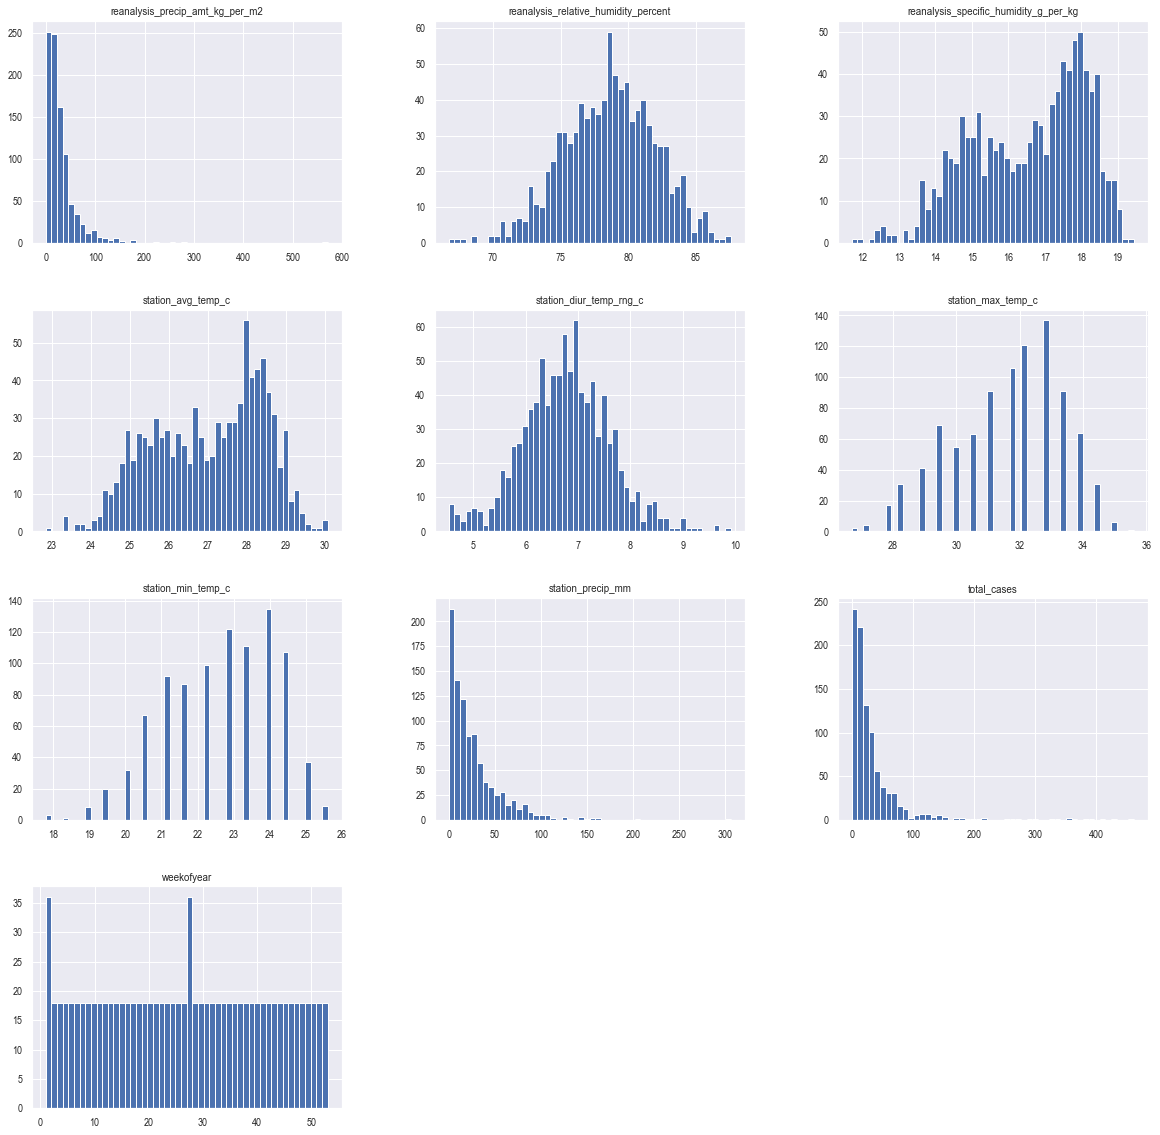

In [28]:
# EDA - Exploring the distributions and empirical cumulative distribution functions of the data
# Plot histograms of all features
_ = sj_feat_1.hist(bins=50, figsize=(20,20))
plt.show()

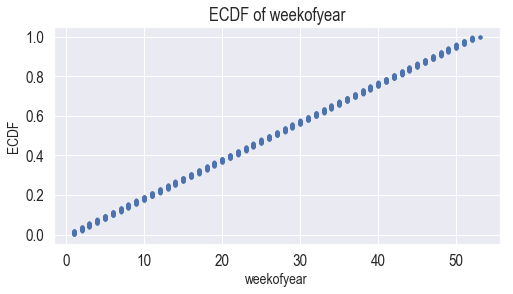

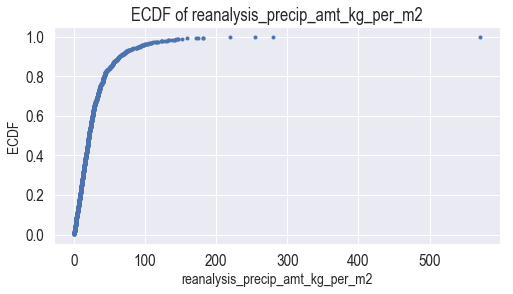

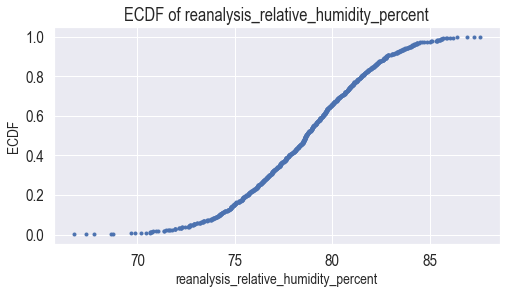

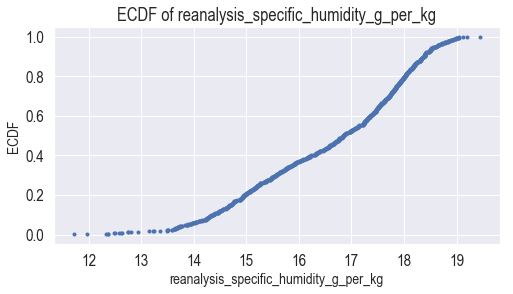

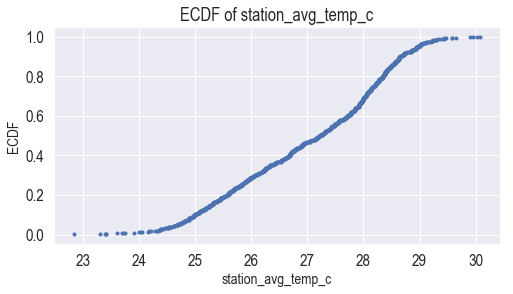

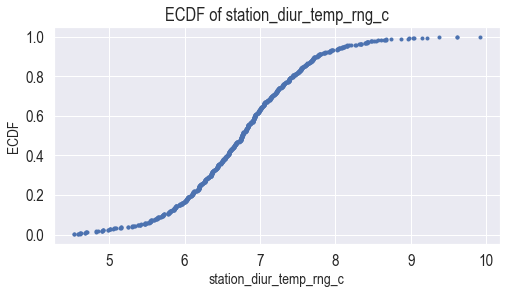

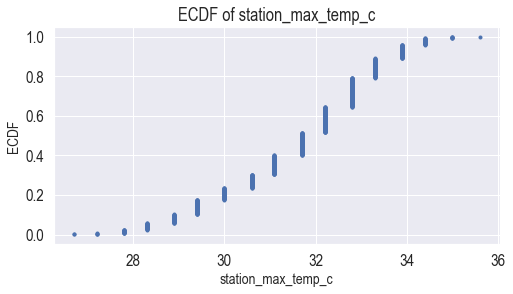

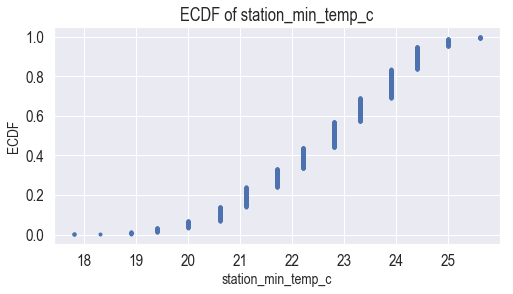

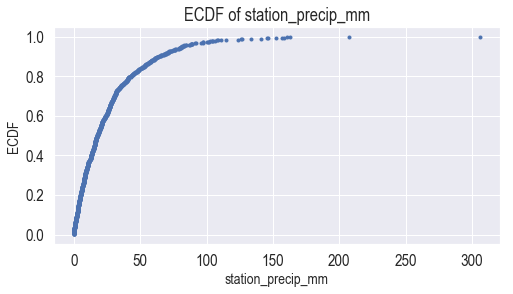

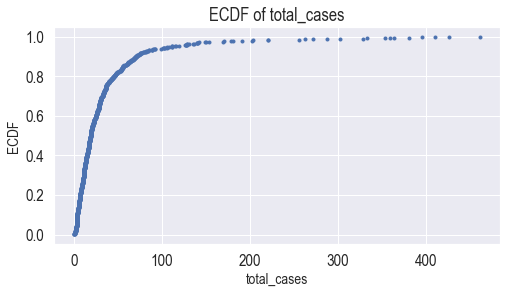

In [15]:
# Plot Empirical cumulative distribution functions for all features
for col in sj_feat_1.columns:
    x_col, y_col = dcst.ecdf(sj_feat[col])
    _ = plt.figure(figsize=(8,4))
    _ = plt.plot(x_col, y_col, marker='.', linestyle='None')
    _ = plt.ylabel('ECDF', fontsize=15)
    _ = plt.xlabel(sj_feat[col].name, fontsize=15)
    _ = plt.title('ECDF of {}'.format(sj_feat[col].name), fontsize=18)
    _ = plt.margins=(0.02)
    plt.show()


From the histograms and ecdfs above:

- station_max/min temperature rounded off to 1 d.p, which may oversimply the true temperature fuctuations from week to week. However, station_avg_temp_c as a smoother distribution. WIll use the station data 'as is' to see how the model performs 
<br>

To do: Confirm the distributions with hacker stats > generate bootstrap replicates of each feature ecdf and perform hypothesis tests



Now that the dataset is reduced to what I think are the most relevant features (at this stage) the missing values need to be imputed. I will use simple linear interpolation (plots a straight line between known values flanking the missing data) as there are only a few data points missing from the features used in this current iteration. I assume this will not bias the overall trend in the data. 

In [16]:
# Impute missing values in the dataset with forward fill
sj_feat_imp = sj_feat_1.interpolate(method='linear')
print('UNIMPUTED {}', sj_feat_1.info())
print('IMPUTED {}',sj_feat_imp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 936 entries, 1990-04-30 to 2008-04-22
Data columns (total 10 columns):
weekofyear                               936 non-null int64
reanalysis_precip_amt_kg_per_m2          930 non-null float64
reanalysis_relative_humidity_percent     930 non-null float64
reanalysis_specific_humidity_g_per_kg    930 non-null float64
station_avg_temp_c                       930 non-null float64
station_diur_temp_rng_c                  930 non-null float64
station_max_temp_c                       930 non-null float64
station_min_temp_c                       930 non-null float64
station_precip_mm                        930 non-null float64
total_cases                              936 non-null int64
dtypes: float64(8), int64(2)
memory usage: 80.4 KB
UNIMPUTED {} None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 936 entries, 1990-04-30 to 2008-04-22
Data columns (total 10 columns):
weekofyear                               936 non-null int64
reanaly

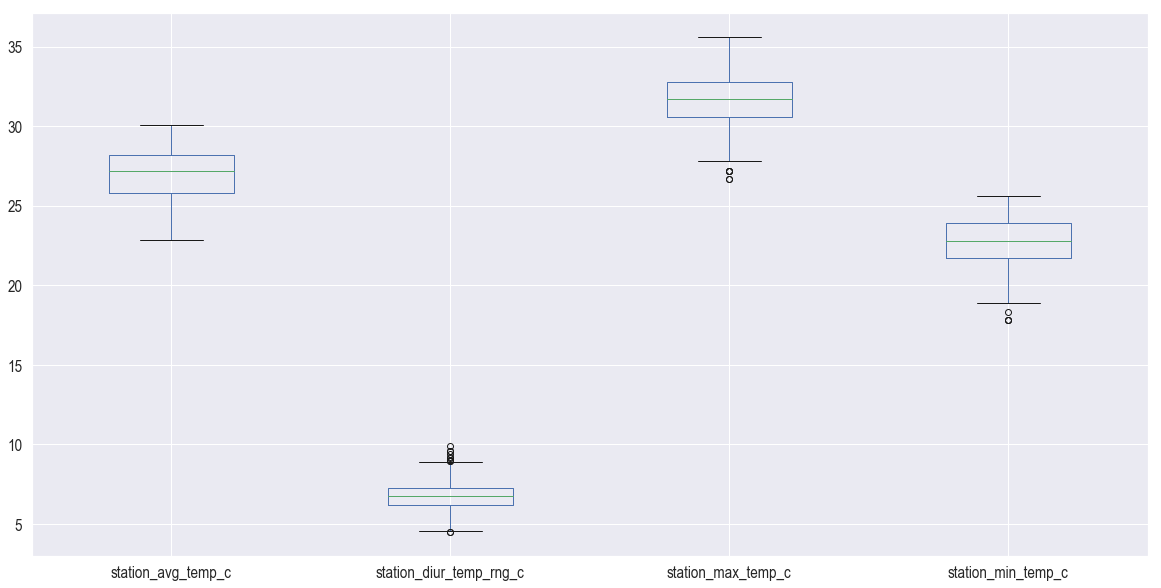

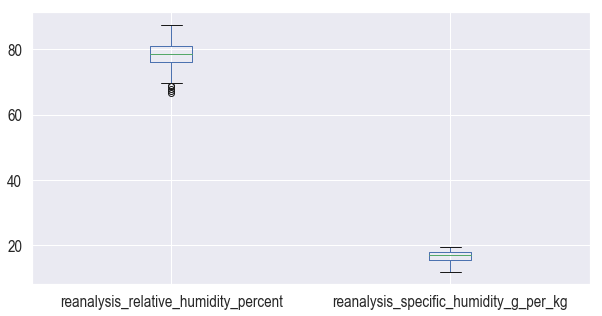

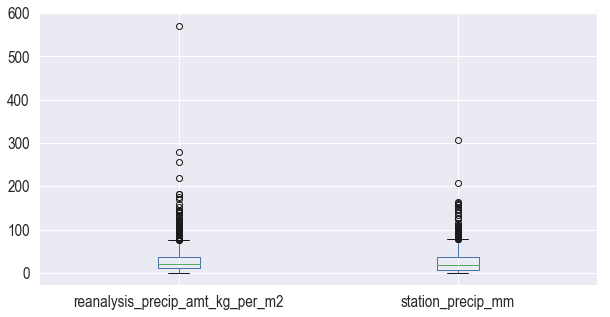

In [17]:
# Assess outliers
_ = plt.figure(figsize=(20,10))
_ = sj_feat_imp[['station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']].boxplot()
plt.show()

_ = plt.figure(figsize=(10,5))
_ = sj_feat_imp[[
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg']].boxplot()
plt.show()

_ = plt.figure(figsize=(10,5))
_ = sj_feat_imp[['reanalysis_precip_amt_kg_per_m2',
       'station_precip_mm']].boxplot()
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


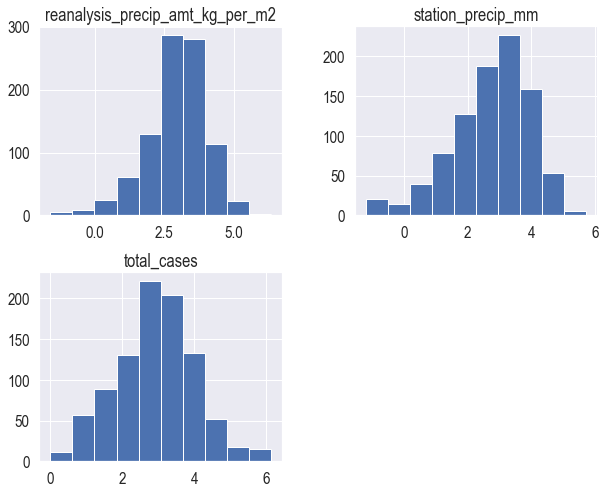

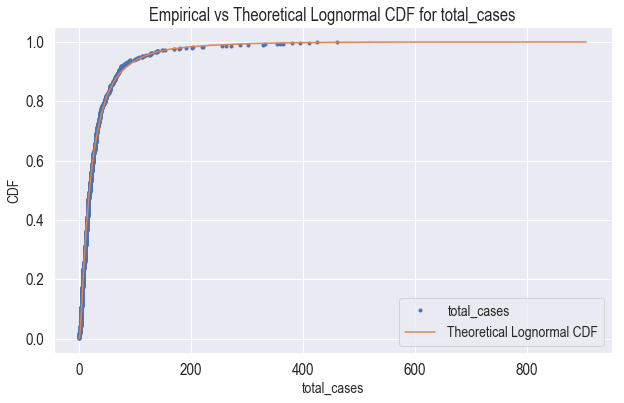

The p value for total_cases for 10000 K-S reps is 0.3667


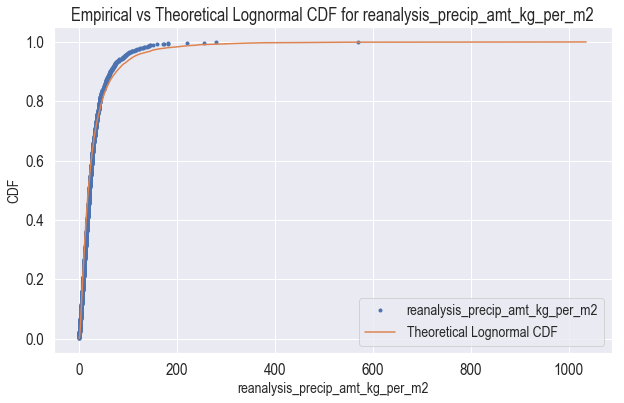

The p value for reanalysis_precip_amt_kg_per_m2 for 10000 K-S reps is 0.0006


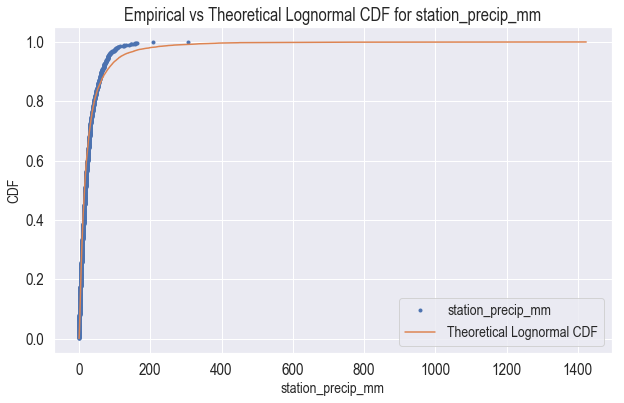

The p value for station_precip_mm for 10000 K-S reps is 0.0087


In [24]:
# Assess outliers by standard deviation
# Determine the distribution of the data (hacker stats, hypothesis test)

### Is the data lognormal?
log_data = np.log(sj_feat_imp[['total_cases','reanalysis_precip_amt_kg_per_m2',
       'station_precip_mm']])

# Log of 0 = infinity, hence need to remove these values
log_data = log_data.replace([np.inf, -np.inf], np.nan).dropna(how='all')

# Plot histograms
_ = log_data.hist(figsize=(10,8))
plt.show()

# Plot theoretical and ecdf according to the hypothesis that the data follows a lognormal distribution
# for total_cases
compare_lognormal_cdf(log_data['total_cases'], sj_feat_imp['total_cases'])

#perform the hypothesis test and compute p-value
derive_lognormal(log_data['total_cases'], sj_feat_imp['total_cases'])

# for 'reanalysis_precip_amt_kg_per_m2'
compare_lognormal_cdf(log_data['reanalysis_precip_amt_kg_per_m2'], 
                      sj_feat_imp['reanalysis_precip_amt_kg_per_m2'])
#perform the hypothesis test and compute p-value
derive_lognormal(log_data['reanalysis_precip_amt_kg_per_m2'], 
                 sj_feat_imp['reanalysis_precip_amt_kg_per_m2'])

# for 'reanalysis_precip_amt_kg_per_m2'
compare_lognormal_cdf(log_data['station_precip_mm'], 
                      sj_feat_imp['station_precip_mm'])
#perform the hypothesis test and compute p-value
derive_lognormal(log_data['station_precip_mm'], 
                 sj_feat_imp['station_precip_mm'])

# If lognormal = True, compute standard deviation as in total cases

The p-value and curve fit for total cases suggest that it follows a lognormal distribution, as shown by 37% of the generated K-S replicates having an equivalent or higher value than the empirical K-S. This is not the case with station_precip_mm and reanalysis_precip_amt_kg_per_m2 as the p-values are too small
<br>
To do: confidence intervals

With the now reduced and cleaned dataset, the optimal lag windows for each features vs. response (total_cases) can be determined. In the next section, I will attempt to find the best lag correlation of each feature with the target/response variable, total_cases. 

Dengue cases that occur today are due to climate fluctuations several weeks prior, because it takes ~ 7-10 days for Aedes mosquitos to complete the egg-to-adult cycle and ~ 4-6 days for dengue symptoms to manifest in infected humans. Hence, we need to look at climate trends several weeks in the past to predict today's total_case count (lag correlation).
 

- Construct a better function to automatically derive the lags/correlation for each feature

In [32]:
print(sj_feat_imp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 936 entries, 1990-04-30 to 2008-04-22
Data columns (total 10 columns):
weekofyear                               936 non-null int64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humidity_percent     936 non-null float64
reanalysis_specific_humidity_g_per_kg    936 non-null float64
station_avg_temp_c                       936 non-null float64
station_diur_temp_rng_c                  936 non-null float64
station_max_temp_c                       936 non-null float64
station_min_temp_c                       936 non-null float64
station_precip_mm                        936 non-null float64
total_cases                              936 non-null int64
dtypes: float64(8), int64(2)
memory usage: 120.4 KB
None


In [38]:
#Compute the highest lag correlations with total cases, up to 24 weeks prior
pd.set_option('display.max_columns', 50)

#col = sj_feat_imp[['reanalysis_precip_amt_kg_per_m2','total_cases']]
#derive_lag_and_spearman(col, 'reanalysis_precip_amt_kg_per_m2', 24,0,-1)

#col = sj_feat_imp[['reanalysis_relative_humidity_percent','total_cases']]
#derive_lag_and_spearman(col, 'reanalysis_relative_humidity_percent', 24,0,-1)

#col = sj_feat_imp[['reanalysis_specific_humidity_g_per_kg','total_cases']]
#derive_lag_and_spearman(col, 'reanalysis_specific_humidity_g_per_kg', 24,0,-1)

#col = sj_feat_imp[['station_avg_temp_c','total_cases']]
#derive_lag_and_spearman(col, 'station_avg_temp_c', 24,0,-1)

#col = sj_feat_imp[['station_min_temp_c','total_cases']]
#derive_lag_and_spearman(col, 'station_min_temp_c', 24,0,-1)

#col = sj_feat_imp[['station_max_temp_c','total_cases']]
#derive_lag_and_spearman(col, 'station_max_temp_c', 24,0,-1)

#col = sj_feat_imp[['station_diur_temp_rng_c','total_cases']]
#derive_lag_and_spearman(col, 'station_diur_temp_rng_c', 24,0,-1)

#col = sj_feat_reduced[['station_precip_mm','total_cases']]
#derive_lag_and_spearman(col, 'station_precip_mm', 24,0,-1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                   station_precip_mm  total_cases      t-24      t-23  \
station_precip_mm           1.000000     0.103451 -0.065201 -0.042801   
total_cases                 0.103451     1.000000 -0.182848 -0.170489   

                       t-22      t-21      t-20      t-19      t-18      t-17  \
station_precip_mm -0.085069 -0.102784 -0.071113 -0.091211 -0.033506 -0.031878   
total_cases       -0.175662 -0.151287 -0.116537 -0.083455 -0.069070 -0.028856   

                       t-16      t-15      t-14      t-13      t-12      t-11  \
station_precip_mm -0.057043 -0.032492  0.029864  0.005603 -0.010753  0.047546   
total_cases       -0.026924  0.012158  0.055702  0.050222  0.073460  0.105188   

                       t-10       t-9       t-8       t-7       t-6       t-5  \
station_precip_mm  0.050794 -0.010534  0.031878  0.069397  0.091425  0.051628   
total_cases        0.118766  0.134383  0.145572  0.149404  0.171013  0.168609   

                        t-4       t-3       t-2 

In [72]:
''' From calculations in the cell above, the optimal lag values are (in weeks):
 
reanalysis_precip_amt_kg_per_m2 8 
reanalysis_relative_humidity_percent 8
reanalysis_specific_humidity_g_per_kg 9 
station_precip_mm 4
station_avg_temp_c 12
station_diur_temp_rng_c 24
station_max_temp_c 12
station_min_temp_c 10'''

# Shift the features according to the derived highest lag correlations above
sj_red_shift = sj_feat_imp[['reanalysis_precip_amt_kg_per_m2']].shift(8)
sj_red_shift['reanalysis_relative_humidity_percent'] = sj_feat_imp[['reanalysis_relative_humidity_percent']].shift(8)
sj_red_shift['reanalysis_specific_humidity_g_per_kg'] = sj_feat_imp[['reanalysis_specific_humidity_g_per_kg']].shift(9)

sj_red_shift['station_precip_mm'] = sj_feat_imp[['station_precip_mm']].shift(4)
sj_red_shift['station_avg_temp_c'] = sj_feat_imp[['station_avg_temp_c']].shift(12)
sj_red_shift['station_max_temp_c'] = sj_feat_imp[['station_max_temp_c']].shift(12)
sj_red_shift['station_min_temp_c'] = sj_feat_imp[['station_min_temp_c']].shift(10)

# Add 'total_cases' and 'weekofyear' into sj_feat_imp
sj_red_shift['total_cases'] = sj_feat_imp[['total_cases']]
sj_red_shift['weekofyear'] = sj_feat_imp[['weekofyear']]

'''NOTE: I removed both diurnal temp range features from the dataset because they have very 
low correlation with total_cases'''

# Slice the dataset to exclude all NaN values generated by shifting the data
sj_red_shift = sj_red_shift.iloc[12:, :]
print(sj_red_shift.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 924 entries, 1990-07-23 to 2008-04-22
Data columns (total 9 columns):
reanalysis_precip_amt_kg_per_m2          924 non-null float64
reanalysis_relative_humidity_percent     924 non-null float64
reanalysis_specific_humidity_g_per_kg    924 non-null float64
station_precip_mm                        924 non-null float64
station_avg_temp_c                       924 non-null float64
station_max_temp_c                       924 non-null float64
station_min_temp_c                       924 non-null float64
total_cases                              924 non-null int64
weekofyear                               924 non-null int64
dtypes: float64(7), int64(2)
memory usage: 72.2 KB
None


The shifted features with highest correlations to the response variable (total_cases) have been determined. Next, I will attempt building an initial model using RandomForestRegressor
<br>

I chose RandomForestRegressor because this algorithm works well with non-parametric, non-stationary, multicollinear and seasonal data (the features in this dataset are a combination of these). Additionally I can extract feature importance metrics to determine which features are the most valuable for predictions, which will help increase my understanding into the mechanism of how climate variables affect dengue incidence and spread. However, RandomForests has not been shown to perform trend projection well (refs) and may not be the most suitable algorithm for time-series extrapolation. Nevertheless, it is a good starter algorithm due to its ease of use, versatility and extractable feature importance metrics. In the next section I perform RandomisedSearchCV with RandomForestRegressor to determine the best parameters for the model.

In [74]:
# Split the dataset into train and test sets
X_sj = sj_red_shift.drop(['total_cases'       
                
                  ], axis=1)
y_sj = sj_red_shift['total_cases']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_sj, y_sj, test_size=0.3, random_state=42, 
                                                                shuffle=False)

In [85]:
#RandomisedSearchCV
#Create dictionary of parameters to explore
param_dist = {'max_depth': [2,4,6,8,10,12,14,16],
              'max_features': [2,3,4,5,6,7],
              'min_samples_split': [10,15,20,25,30,35,40],
              'min_samples_leaf' : [5,10,15,20,25],
              'min_impurity_decrease' : [0,0.1,0.2,0.3,0.5]
             }
# Create a random forest regression model
rfr = RandomForestRegressor(n_estimators=300, random_state=42, criterion='mae')

# Create a scorer to use (use the mean squared error)
scorer = make_scorer(mean_absolute_error)

# Build a random search using param_dist, rfr, and scorer
rs =\
    RandomizedSearchCV(
        estimator=rfr,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring=scorer)
rs.fit(X_sj, y_sj)

# print the mean test scores:
print('The accuracy for each run was: {}.'.format(rs.cv_results_['mean_test_score']))

# print the best model score:
print('The best accuracy for a single model was: {}'.format(rs.best_score_))

# print the best paramaters
print('The best paramaters were: {}'.format(rs.best_estimator_))

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The accuracy for each run was: [23.17244228 22.99326659 23.57037518 23.38149351 23.02310606 23.08641053
 22.82433081 22.87859848 23.27607684 23.39738817].
The best accuracy for a single model was: 23.57037518037518
The best paramaters were: RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=16,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


(278, 1)


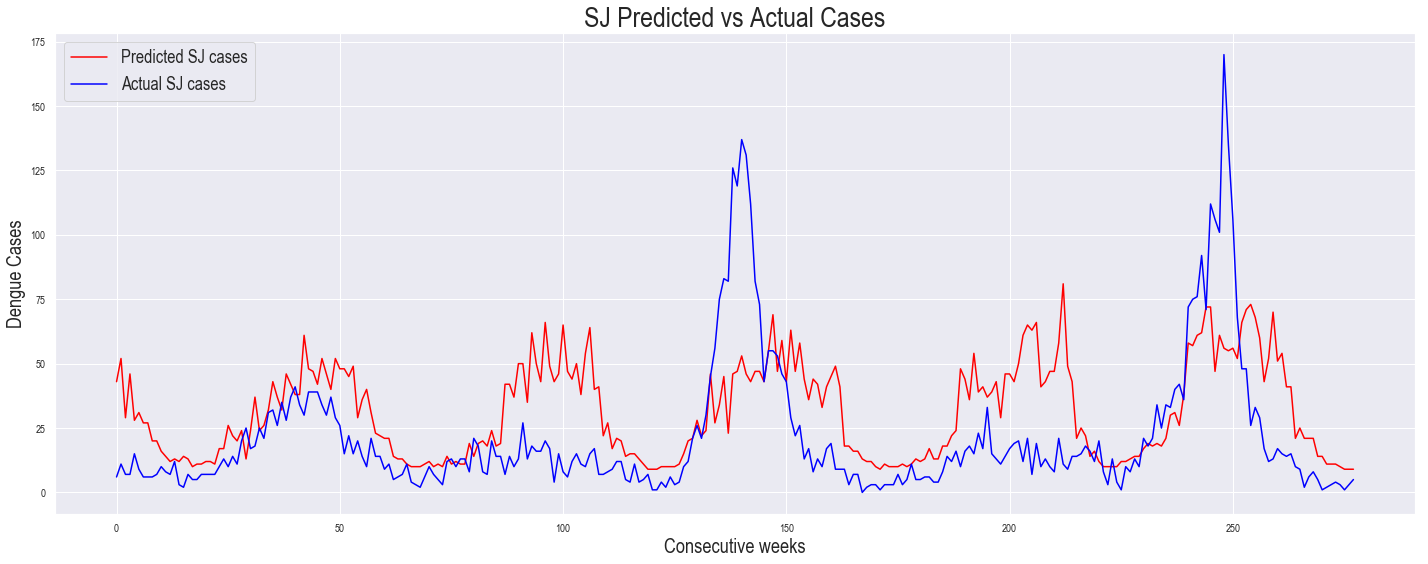

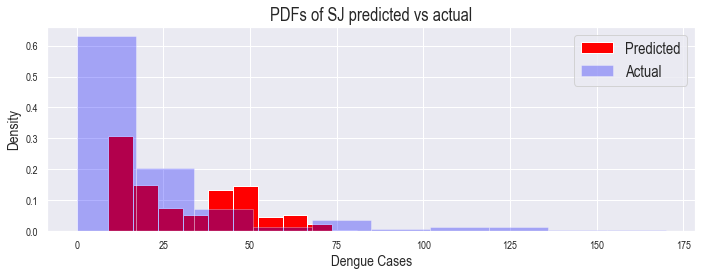

Cross val MAE sj: -14.247163852813852
Cross val MSE sj: -694.6106901854257
MAE score sj: 18.402877697841728
Accuracy sj test set: 2.2%
Accuracy sj training set: 2.3%


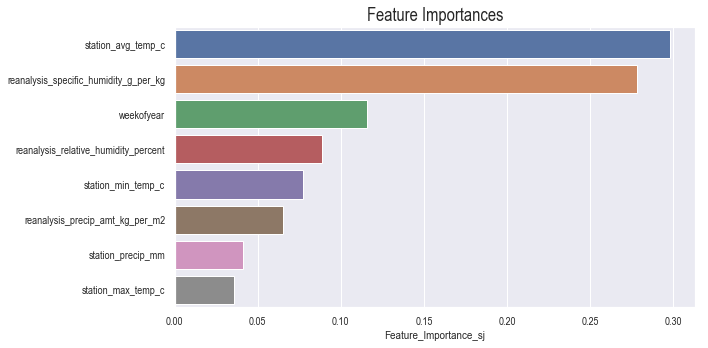

Index(['station_avg_temp_c', 'reanalysis_specific_humidity_g_per_kg',
       'weekofyear', 'reanalysis_relative_humidity_percent',
       'station_min_temp_c', 'reanalysis_precip_amt_kg_per_m2',
       'station_precip_mm', 'station_max_temp_c'],
      dtype='object')


In [86]:
#fit and predict on sj data
clf_sj = RandomForestRegressor(random_state=42, max_depth=16, criterion='mae', 
                                max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=40,
                      min_weight_fraction_leaf=0.0,       
                              n_estimators=300, n_jobs=-1)
clf_sj.fit(Xtrain, ytrain)
z1 = clf_sj.predict(Xtest)
z_sj = pd.DataFrame(np.round(z1), index=Xtest.index, columns=['Predicted SJ Cases'])
#pd.DataFrame(np.round(z1), index=Xtest.index, columns=['Predicted SJ Cases'])
train_pred = np.round(clf_sj.predict(Xtrain))
print(z_sj.shape)

#plot ecdfs of SJ predictions and total_cases
predictions_sj = np.array(z_sj['Predicted SJ Cases'])
actuals_sj = np.array(ytest)
_ = plt.figure(figsize=(20,8))
_ = plt.plot(predictions_sj, color='red', label='Predicted SJ cases')
_ = plt.plot(actuals_sj, color='blue', label='Actual SJ cases')
_ = plt.title('SJ Predicted vs Actual Cases', fontsize=28)
_ = plt.xlabel('Consecutive weeks', fontsize=20)
_ = plt.ylabel('Dengue Cases', fontsize=20)
_ = plt.legend(fontsize=18)
plt.tight_layout()
#plt.savefig('D:\Coding related\Driven Data related\DengAi comp\datasets\saved figures\RFC SJ PvsA 20 or more cases baseline.png')
plt.show()

#EDA on predicted vs actual
#normalise the histogram area summing up to 1
weights_pred_sj = np.ones_like(predictions_sj)/float(len(predictions_sj))
weights_act_sj = np.ones_like(actuals_sj)/float(len(actuals_sj))

_ = plt.figure(figsize=(10,4))
_ = plt.hist(predictions_sj, weights=weights_pred_sj, density=False, color='red', label='Predicted')
_ = plt.hist(actuals_sj,  weights=weights_act_sj, density=False, color='blue', alpha=0.3, label='Actual')
_ = plt.title('PDFs of SJ predicted vs actual', fontsize=(18))
_ = plt.xlabel('Dengue Cases', fontsize=15)
_ = plt.ylabel('Density', fontsize=15)
_ = plt.legend(fontsize=16)
plt.tight_layout()
#plt.savefig('D:\Coding related\Driven Data related\DengAi comp\datasets\saved figures\RFC PDF SJ 20 or more baseline.png')
plt.show()

#set a timeseries split
tcsv = TimeSeriesSplit(n_splits=5)
#validate the sj model
score_sj = cross_val_score(clf_sj, Xtest, ytest, cv=5, scoring='neg_mean_absolute_error')
score_mse_sj = cross_val_score(clf_sj, Xtest, ytest, cv=5, scoring='neg_mean_squared_error')
print('Cross val MAE sj: {}'.format(score_sj.mean()))
print('Cross val MSE sj: {}'.format(score_mse_sj.mean()))
print('MAE score sj: {}'.format(mean_absolute_error(ytest, z_sj)))
print('Accuracy sj test set: {0:.1%}'.format(accuracy_score(ytest, z_sj)))
print('Accuracy sj training set: {0:.1%}'.format(accuracy_score(ytrain, train_pred)))

# Feature importance assesment 
#SJ data and fit
sj_feat_importance = pd.DataFrame(clf_sj.feature_importances_, index=Xtrain.columns, 
                                  columns=['Feature_Importance_sj']).sort_values('Feature_Importance_sj', 
                                                                              ascending=False)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(y = sj_feat_importance.index, x='Feature_Importance_sj', data= sj_feat_importance
               )
_ = plt.title('Feature Importances', fontsize=18)
plt.tight_layout()
#plt.savefig('D:\Coding related\Driven Data related\DengAi comp\datasets\saved figures\importance RFC 20 or more cases baseline.png')
plt.show()
print(sj_feat_importance.index)

Discussion:
- There model has a heavy bias, as shown by the plot of overlayed predicted vs actual trends and also by the similar but very low test vs training set accuracies. It is not capturing the underlying trend/seasonality and appears to simply be averaging the the total_case count between years that have spikes in total_cases (epidemics) and years that do not  
<br>
- The high cross-validated MSE score indicates that there are large prediction errors, also shown in the time-series plot of overlayed predictions vs. actual dengue cases. Similarly the high cross-validated MAE score indicates that the model will likely not generalise to unseen data well
<br>

- This is likely due to the class imbalance in the total_cases data (response variable). Total_cases count have large spikes for a few months at year ends (epidemic season) while some years have no epidemics. Will explore resampling techniques (to balance the minority values) such as SMOTE for regression to solve this problem
<br>
<br>
- Up till now I was assuming a very static relationship between lag correlations of climate features vs. total_cases - for example if I computed the highest correlation of feature vs total_cases at 5 weeks, I would just assume that the 5 week lag holds throughout the entire 18 years and just shift the feature data back 5 weeks w.r.t to total_cases for the entire dataset. 
<br>
In reality however, there are climate seasons throughout the year which would result in different optimal lag correlations for each season (possibly each year too). For example, in the dry season a lag of 5 weeks might produce the highest correlation with total_cases, but in the wet season in that same year the highest correlation might be 3 weeks. 
<br>
So in the next iteration, I will attempt to subset the features according to seasons, compute optimal correlations for each season, then shift the data accordingly. This might improve the prediction accuracy.
<br>

Next iteration:
<br>
- use dummy variables to describe seasons, add these as new features. Eg: rainy vs dry vs warmer months
- compute lag correlations of features according to seasons
- address the class imbalance of the response variable (total_cases)
- reiterate pipeline with RFRegressor and assess result. If the results are still not suitable, try a different algorithm